# ESTUDO E RESOLUÇÃO DO CICLO DE RANKINE COM MODIFICAÇÕES

---

## Descrição do Problema Proposto

A figura a seguir contém o esquema do ciclo termodinâmico de potência
a ser avaliado neste trabalho:

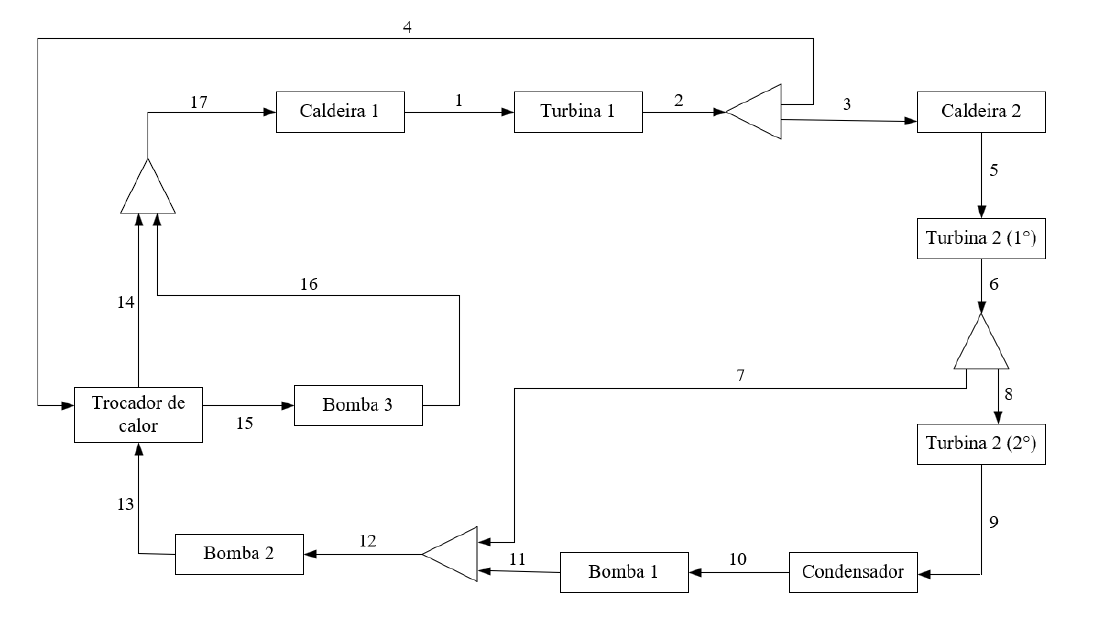

In [2784]:
from IPython.display import Image
Image('./images/esquema-problema.png')

As hipóteses para serem adotadas para o ciclo:

 - Fluido de trabalho: vapor d’água;
 - Perda de carga desprezível nos equipamentos de troca térmica;
 - Operação isentrópica das turbinas e das bombas;
 - Vazão mássica (ṁ) da corrente 1 fixa em 10.000 kg/h;
 - Saída do condensador (corrente 10): líquido saturado.

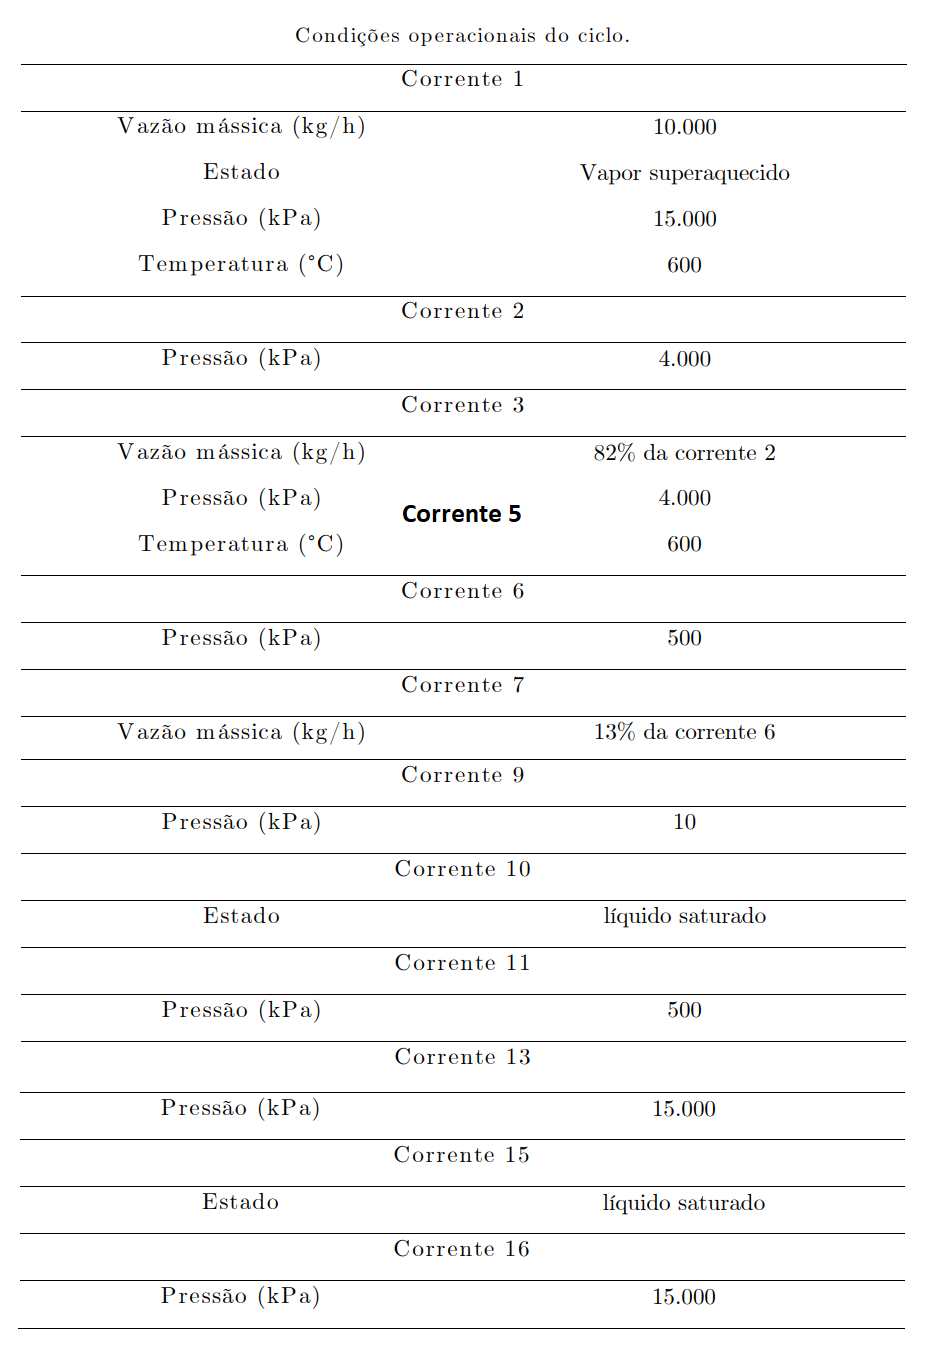

In [2785]:
Image('./images/tabela-correntes.png')

a) Determinar a eficiência térmica do sistema modificado proposto;

b) Obter a taxa de trabalho realizado em cada turbina; a taxa de calor
fornecido nas caldeiras; a taxa de trabalho consumida em cada bomba;

c) Determinar a vazão mássica de água de resfriamento empregada no
condensador.

d) Construir o diagrama T x s do sistema.

e) Realizar análise paramétrica no desempenho do ciclo considerando a
variação das pressões de descargas das turbinas; e a temperatura de saída
da caldeira 1; (para esta análise, plote gráficos para demonstrar a influência
desses parâmetros na eficiência térmica do ciclo). Discuta os resultados
obtidos.

In [2786]:
# Pacotes necessários para a execução do código

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
from IPython.display import display, Math, Latex

In [2787]:
# Tabela onde serão armazenados os dados

colunas = ['Corrente', 'Pressão (kPa)', 'Temperatura (°C)', 'Entalpia (kJ/kg)', 'Entropia (kJ/kg·K)', 'Estado', 'ṁ (kg/h)']
df = pd.DataFrame(columns=colunas)

In [2788]:
def obter_propriedades(P, T=None, x=None, s=None):
    """Retorna h (kJ/kg) e s (kJ/kg·K) para um dado estado.

    Args:
        P (float): Pressão (kPa).
        T (float, optional): Temperatura (°C). Defaults to None.
        x (float, optional): Título. Defaults to None.
        s (float, optional): Entropia (kJ/kg·K). Defaults to None.

    Returns:
        tuple: h (kJ/kg) e s (kJ/kg·K).
    """
    # Estado definido por P e T
    if T is not None:
        h = CP.PropsSI('H', 'P', P, 'T', T, 'Water') / 1000  # kJ/kg
        s = CP.PropsSI('S', 'P', P, 'T', T, 'Water') / 1000  # kJ/kg·K
    # Estado definido por P e título
    elif x is not None:
        h = CP.PropsSI('H', 'P', P, 'Q', x, 'Water') / 1000
        s = CP.PropsSI('S', 'P', P, 'Q', x, 'Water') / 1000
    # Estado definido por P e entropia (processo isentrópico)
    elif s is not None:
        try:
            # s em kJ/kg·K → J/kg·K
            h = CP.PropsSI('H', 'P', P, 'S', s*1000, 'Water') / 1000
        except:
            # Calcular título se for mistura
            s_liq = CP.PropsSI('S', 'P', P, 'Q', 0, 'Water') / 1000
            s_vap = CP.PropsSI('S', 'P', P, 'Q', 1, 'Water') / 1000
            x = (s - s_liq) / (s_vap - s_liq)
            h = CP.PropsSI('H', 'P', P, 'Q', x, 'Water') / 1000
    return h, s

In [2789]:
# Ponto 1: Saída da Caldeira 1 (15 MPa, 600°C)

P1 = 15000     # kPa
T1 = 600       # °C
h1, s1 = obter_propriedades(P1*1e3, T=T1+273.15)
m_dot1 = 10000 # kg/h

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [1, P1, T1, h1, s1, 'Vapor superaquecido', m_dot1]
df.iloc[-1]

Corrente                                1
Pressão (kPa)                       15000
Temperatura (°C)                      600
Entalpia (kJ/kg)              3583.131761
Entropia (kJ/kg·K)                6.67959
Estado                Vapor superaquecido
ṁ (kg/h)                            10000
Name: 0, dtype: object

In [2790]:
# Ponto 2: Saída da Turbina 1 (4 MPa, expansão isentrópica)

P2 = 4000  # kPa
m_dot2 = m_dot1
h2, s2 = obter_propriedades(P2*1e3, s=s1)  # s2 = s1
T2 = CP.PropsSI('T', 'P', P2*1e3, 'H', h2*1000, 'Water') - 273.15

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [2, P2, round(T2,1), h2, s2, 'Mistura' if 0 < (h2 - CP.PropsSI('H', 'P', P2*1e3, 'Q', 0, 'Water')/1000) < (CP.PropsSI('H', 'P', P2*1e3, 'Q', 1, 'Water')/1000 - CP.PropsSI('H', 'P', P2*1e3, 'Q', 0, 'Water')/1000) else 'Vapor', m_dot2]
df.iloc[-1]

Corrente                        2
Pressão (kPa)                4000
Temperatura (°C)            374.7
Entalpia (kJ/kg)      3153.874543
Entropia (kJ/kg·K)        6.67959
Estado                      Vapor
ṁ (kg/h)                    10000
Name: 1, dtype: object

In [2791]:
# Trabalho da Turbina 1

Wt1 = (m_dot1/3600) * (h1 - h2)  # kW
display(Math(r'\dot{W}_{t1} = %.2f \, \text{kW}' % Wt1))

<IPython.core.display.Math object>

In [2792]:
# Ponto 3: Entrada da Caldeira 2

P3 = P2
m_dot3 = 0.82 * m_dot1
h3 = h2
s3 = s2
T3 = T2

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [3, P3, T3 ,h3,s3,'-', m_dot3]
df.iloc[-1]

Corrente                        3
Pressão (kPa)                4000
Temperatura (°C)       374.656993
Entalpia (kJ/kg)      3153.874543
Entropia (kJ/kg·K)        6.67959
Estado                          -
ṁ (kg/h)                   8200.0
Name: 2, dtype: object

In [2793]:
# Ponto 4: Saída do splitter e entrada do Trocador de Calor

P4 = P3
m_dot4 = 0.18 * m_dot1
T4 = T2
h4 = h2
s4 = s2

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [4, P4, T4, h4, s4, '-', m_dot4]
df.iloc[-1]

Corrente                        4
Pressão (kPa)                4000
Temperatura (°C)       374.656993
Entalpia (kJ/kg)      3153.874543
Entropia (kJ/kg·K)        6.67959
Estado                          -
ṁ (kg/h)                   1800.0
Name: 3, dtype: object

In [2794]:
# Ponto 5: Saída da Caldeira 2 (4 MPa, 600°C) - Correção da errata

P5 = 4000  # kPa
T5 = 600   # °C
m_dot5 = m_dot3
h5, s5 = obter_propriedades(P5*1e3, T=T5+273.15)

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [5, P5, T5, h5, s5, 'Vapor superaquecido', m_dot5]
df.iloc[-1]

Corrente                                5
Pressão (kPa)                        4000
Temperatura (°C)                    600.0
Entalpia (kJ/kg)              3674.867523
Entropia (kJ/kg·K)               7.370528
Estado                Vapor superaquecido
ṁ (kg/h)                           8200.0
Name: 4, dtype: object

In [2795]:
# Calor fornecido pela Caldeira 2

Q_in_cald2 = (m_dot5/3600) * (h5 - h4)  # kW
display(Math(r'\dot{Q}_{\text{in, cald 2}} = %.2f \, \text{kW}' % Q_in_cald2))

<IPython.core.display.Math object>

In [2796]:
# Ponto 6: Saída da Turbina 2 (1° Estágio) (500 kPa, expansão isentrópica)

P6 = 500  # kPa
h6, s6 = obter_propriedades(P6*1e3, s=s5)  # s6 = s5
m_dot6 = m_dot5
T6 = CP.PropsSI('T', 'P', P6*1e3, 'H', h6*1000, 'Water') - 273.15

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [6, P6, round(T6,1), h6, s6, '-', m_dot6]
df.iloc[-1]

Corrente                        6
Pressão (kPa)                 500
Temperatura (°C)            275.4
Entalpia (kJ/kg)      3013.589893
Entropia (kJ/kg·K)       7.370528
Estado                          -
ṁ (kg/h)                   8200.0
Name: 5, dtype: object

In [2797]:
# Trabalho da Turbina 2 (1° Estágio)

Wt2_1est = (m_dot5/3600) * (h5 - h6)  # kW
display(Math(r'\dot{W}_{t2, 1\text{° est}} = %.2f \, \text{kW}' % Wt2_1est))

<IPython.core.display.Math object>

In [2798]:
# Ponto 7: Saída da Turbina 2 após passar por um splitter

P7 = P6  # Mesma pressão
m_dot7 = 0.13 * m_dot6
h7 = h6
s7 = s6
T7 = T6

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [7, P7, T7, h7, s7, '-', m_dot7]
df.iloc[-1]

Corrente                        7
Pressão (kPa)                 500
Temperatura (°C)        275.35071
Entalpia (kJ/kg)      3013.589893
Entropia (kJ/kg·K)       7.370528
Estado                          -
ṁ (kg/h)                   1066.0
Name: 6, dtype: object

In [2799]:
# Ponto 8:

P8 = P6
m_dot8 = 0.87 * m_dot6
h8 = h6
s8 = s6
T8 = T6

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [8, P8, T8, h8, s8, '-', m_dot8]
df.iloc[-1]

Corrente                        8
Pressão (kPa)                 500
Temperatura (°C)        275.35071
Entalpia (kJ/kg)      3013.589893
Entropia (kJ/kg·K)       7.370528
Estado                          -
ṁ (kg/h)                   7134.0
Name: 7, dtype: object

In [2800]:
# Ponto 9: Saída da Turbina 2 (2° Estágio) (10 kPa, expansão isentrópica)

P9 = 10  # kPa
s9 = s6
h9, _ = obter_propriedades(P9*1e3, s=s9)
m_dot9 = m_dot8
T9 = CP.PropsSI('T', 'P', P9*1e3, 'H', h9*1000, 'Water') - 273.15

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [9, P9, round(T9,1), h9, s9, 'Vapor úmido', m_dot9]
df.iloc[-1]

Corrente                        9
Pressão (kPa)                  10
Temperatura (°C)             45.8
Entalpia (kJ/kg)      2335.617568
Entropia (kJ/kg·K)       7.370528
Estado                Vapor úmido
ṁ (kg/h)                   7134.0
Name: 8, dtype: object

In [2801]:
# Trabalho da Turbina 2 (2° Estágio)

Wt2_2est = (m_dot8/3600) * (h8 - h9)  # kW
display(Math(r'\dot{W}_{t2, 2\text{° est}} = %.2f \, \text{kW}' % Wt2_2est))

<IPython.core.display.Math object>

In [2802]:
# Ponto 10: Saída do Condensador

P10 = P9
m_dot10 = m_dot9
h10 = CP.PropsSI('H', 'P', P10*1e3, 'Q', 0, 'Water') / 1000
s10 = CP.PropsSI('S', 'P', P10*1e3, 'Q', 0, 'Water') / 1000
T10 = CP.PropsSI('T', 'P', P10*1e3, 'Q', 0, 'Water') - 273.15

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [10, P10, round(T10,1), h10, s10, 'Líquido saturado', m_dot10]
df.iloc[-1]

Corrente                            10
Pressão (kPa)                       10
Temperatura (°C)                  45.8
Entalpia (kJ/kg)            191.805945
Entropia (kJ/kg·K)            0.649196
Estado                Líquido saturado
ṁ (kg/h)                        7134.0
Name: 9, dtype: object

In [2803]:
# Calor retirado pelo Condensador

Q_out_cond = (m_dot9/3600) * (h9 - h10)  # kW
display(Math(r'\dot{Q}_{\text{out, cond}} = %.2f \, \text{kW}' % Q_out_cond))

<IPython.core.display.Math object>

In [2804]:
# Ponto 11: Saída da Bomba 1

P11 = 500  # kPa (pressão aumentada para regeneração)
h11 = h10 + (P11*1e3 - P10*1e3)/(1000 * 1000)  # Trabalho da bomba simplificado
s11 = s10
m_dot11 = m_dot10
T11 = CP.PropsSI('T', 'P', P11*1e3, 'H', h11*1000, 'Water') - 273.15

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [11, P11, round(T11,1), h11, s11, 'Líquido comprimido', m_dot11]
df.iloc[-1]

Corrente                              11
Pressão (kPa)                        500
Temperatura (°C)                    45.8
Entalpia (kJ/kg)              192.295945
Entropia (kJ/kg·K)              0.649196
Estado                Líquido comprimido
ṁ (kg/h)                          7134.0
Name: 10, dtype: object

In [2805]:
# Trabalho da Bomba 1

Wb1 = (m_dot10/3600) * (h11 - h10)  # kW
display(Math(r'\dot{W}_{b1} = %.2f \, \text{kW}' % Wb1))

<IPython.core.display.Math object>

In [2806]:
# Ponto 12: Mistura dos fluxos 7 e 11

P12 = P11
m_dot12 = m_dot11 + m_dot7
h12 = (m_dot11 * h11 + m_dot7 * h7) / m_dot12
s12 = CP.PropsSI('S', 'P', P12*1e3, 'H', h12*1000, 'Water') / 1000
T12 = CP.PropsSI('T', 'P', P12*1e3, 'H', h12*1000, 'Water') - 273.15

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [12, P12, round(T12,1), h12, s12, 'Mistura', m_dot12]
df.iloc[-1]

Corrente                      12
Pressão (kPa)                500
Temperatura (°C)           132.9
Entalpia (kJ/kg)      559.064158
Entropia (kJ/kg·K)      1.665377
Estado                   Mistura
ṁ (kg/h)                  8200.0
Name: 11, dtype: object

In [2807]:
# Ponto 13: Saída da Bomba 2

P13 = 15000  # kPa
m_dot13 = m_dot12
s13 = s12
h13 = CP.PropsSI('H', 'P', P13*1e3, 'S', s13*1000, 'Water') / 1000
T13 = CP.PropsSI('T', 'P', P13*1e3, 'H', h13*1000, 'Water') - 273.15

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [13, P13, round(T13,1), h13, s13, 'Líquido comprimido', m_dot13]
df.iloc[-1]

Corrente                              13
Pressão (kPa)                      15000
Temperatura (°C)                   134.3
Entalpia (kJ/kg)              574.562176
Entropia (kJ/kg·K)              1.665377
Estado                Líquido comprimido
ṁ (kg/h)                          8200.0
Name: 12, dtype: object

In [2808]:
# Trabalho da Bomba 2

Wb2 = (m_dot12/3600) * (h13 - h12)  # kW
display(Math(r'\dot{W}_{b2} = %.2f \, \text{kW}' % Wb2))

<IPython.core.display.Math object>

In [2809]:
# Ponto 14: (saída do trocador de calor)

P14 = P13
h14 = (m_dot13 * h13 + m_dot4 * h4) / (m_dot13 + m_dot4)
s14 = CP.PropsSI('S', 'P', P14*1e3, 'H', h14*1000, 'Water') / 1000
T14 = CP.PropsSI('T', 'P', P14*1e3, 'H', h14*1000, 'Water') - 273.15
m_dot14 = m_dot13

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [14, P14, round(T14,1), h14, s14, 'Mistura', m_dot14]
df.iloc[-1]

Corrente                       14
Pressão (kPa)               15000
Temperatura (°C)            239.9
Entalpia (kJ/kg)      1038.838402
Entropia (kJ/kg·K)       2.676767
Estado                    Mistura
ṁ (kg/h)                   8200.0
Name: 13, dtype: object

In [2810]:
# Ponto 15: Saída do trocador de calor para bomba 3

P15 = P4
m_dot15 = m_dot4
h15 = CP.PropsSI('H', 'P', P15*1e3, 'Q', 0, 'Water') / 1000
s15 = CP.PropsSI('S', 'P', P15*1e3, 'Q', 0, 'Water') / 1000
T15 = CP.PropsSI('T', 'P', P15*1e3, 'Q', 0, 'Water') - 273.15

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [15, P15, T15, h15, s15, 'Líquido Saturado', m_dot15]
df.iloc[-1]

Corrente                            15
Pressão (kPa)                     4000
Temperatura (°C)            250.354045
Entalpia (kJ/kg)           1087.491597
Entropia (kJ/kg·K)            2.796762
Estado                Líquido Saturado
ṁ (kg/h)                        1800.0
Name: 14, dtype: object

In [2811]:
# Ponto 16: Saída da Bomba 3

P16 = 15000  # kPa
m_dot16 = m_dot15
s16 = s15
h16 = CP.PropsSI('H', 'P', P16*1e3, 'S', s16*1000, 'Water') / 1000
T16 = CP.PropsSI('T', 'P', P16*1e3, 'H', h16*1000, 'Water') - 273.15

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [16, P16, round(T16,1), h16, s16, 'Líquido comprimido', m_dot16]
df.iloc[-1]

Corrente                              16
Pressão (kPa)                      15000
Temperatura (°C)                   253.2
Entalpia (kJ/kg)             1101.199858
Entropia (kJ/kg·K)              2.796762
Estado                Líquido comprimido
ṁ (kg/h)                          1800.0
Name: 15, dtype: object

In [2812]:
# Trabalho da Bomba 3

Wb3 = (m_dot15/3600) * (h16 - h15)  # kW
display(Math(r'\dot{W}_{b3} = %.2f \, \text{kW}' % Wb3))

<IPython.core.display.Math object>

In [2813]:
# Ponto 17: Mistura dos fluxos 16 e 14

P17 = P16
m_dot17  = m_dot16 + m_dot14
h17 = (m_dot16 * h16 + m_dot14 * h14) / m_dot17
s17 = CP.PropsSI('S', 'P', P17*1e3, 'H', h17*1000, 'Water') / 1000
T17 = CP.PropsSI('T', 'P', P17*1e3, 'H', h17*1000, 'Water') - 273.15

# Adicionar dados à tabela para uso posterior

df.loc[len(df)] = [17, P17, round(T17,1), h17, s17, 'Mistura', m_dot17]
df.set_index('Corrente', inplace=True)
df_correntes = df[['Pressão (kPa)', 'Temperatura (°C)', 'Entalpia (kJ/kg)', 'Entropia (kJ/kg·K)', 'ṁ (kg/h)']]
df_correntes

,Pressão (kPa),Temperatura (°C),Entalpia (kJ/kg),Entropia (kJ/kg·K),ṁ (kg/h)
Corrente,,,,,
1,15000,600.000000,3583.131761,6.679590,10000.0
2,4000,374.700000,3153.874543,6.679590,10000.0
3,4000,374.656993,3153.874543,6.679590,8200.0
4,4000,374.656993,3153.874543,6.679590,1800.0
5,4000,600.000000,3674.867523,7.370528,8200.0
6,500,275.400000,3013.589893,7.370528,8200.0
7,500,275.350710,3013.589893,7.370528,1066.0
8,500,275.350710,3013.589893,7.370528,7134.0
9,10,45.800000,2335.617568,7.370528,7134.0


In [2814]:
# Salvar tabela em arquivo Excel e Latex

df_correntes.to_excel('TabelaCorrentes-Propriedades.xlsx')
df_correntes.to_latex('TabelaCorrentes-Propriedades.tex')

In [2815]:
# Calor fornecido pela Caldeira 1

Q_in_cald1 = (m_dot1/3600) * (h1 - h17)  # kW
display(Math(r'\dot{Q}_{\text{in, cald 1}} = %.2f \, \text{kW}' % Q_in_cald1))

<IPython.core.display.Math object>

---

a) Determinar a eficiência térmica do sistema modificado proposto;

In [2816]:
# Eficiência térmica

eta = (Wt1 + Wt2_1est + Wt2_2est - Wb1 - Wb2 - Wb3) / (Q_in_cald1 + Q_in_cald2)
display(Math(r'\eta = \frac{\dot{W}_{liq}}{\dot{Q}_{h}} = %.4f = %.2f \, \%%' % (eta, eta * 100)))

<IPython.core.display.Math object>

b) Obter a taxa de trabalho realizado em cada turbina; a taxa de calor 
fornecido nas caldeiras; a taxa de trabalho consumida em cada bomba;

In [2817]:
# Taxas de trabalho e calor de cada componente

display(Math(r'\dot{W}_{turbina \ 1} = %.2f \, \text{kW}' % Wt1))
display(Math(r'\dot{W}_{turbina \ 2, 1\text{° est}} = %.2f \, \text{kW}' % Wt2_1est))
display(Math(r'\dot{W}_{turbina \ 2, 2\text{° est}} = %.2f \, \text{kW}' % Wt2_2est))
display(Math(r'\dot{W}_{bomba \ 1} = %.2f \, \text{kW}' % Wb1))
display(Math(r'\dot{W}_{bomba \ 2} = %.2f \, \text{kW}' % Wb2))
display(Math(r'\dot{W}_{bomba \ 3} = %.2f \, \text{kW}' % Wb3))
display(Math(r'\dot{Q}_{cald \ 1} = %.2f \, \text{kW}' % Q_in_cald1))
display(Math(r'\dot{Q}_{cald \ 2} = %.2f \, \text{kW}' % Q_in_cald2))
display(Math(r'\dot{Q}_{cond} = %.2f \, \text{kW}' % Q_out_cond))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

c) Determinar a vazão mássica de água de resfriamento empregada no 
condensador.

In [2818]:
# Vazão mássica de água de resfriamento no condensador

cp = 4.18  # kJ/kg·K

# Considerando que a água de resfriamento entra a 25°C e sai a 40°C
ΔT = 15  # K
Q_out_cond = Q_out_cond * 1e3  # W
m_resf_agua = Q_out_cond / (cp * ΔT)  # kg/s
display(Math(r'\dot{m}_{\text{água, resf}} = %.2f \, \text{kg/s}' % m_resf_agua))

<IPython.core.display.Math object>

d) Construir o diagrama T x s do sistema.

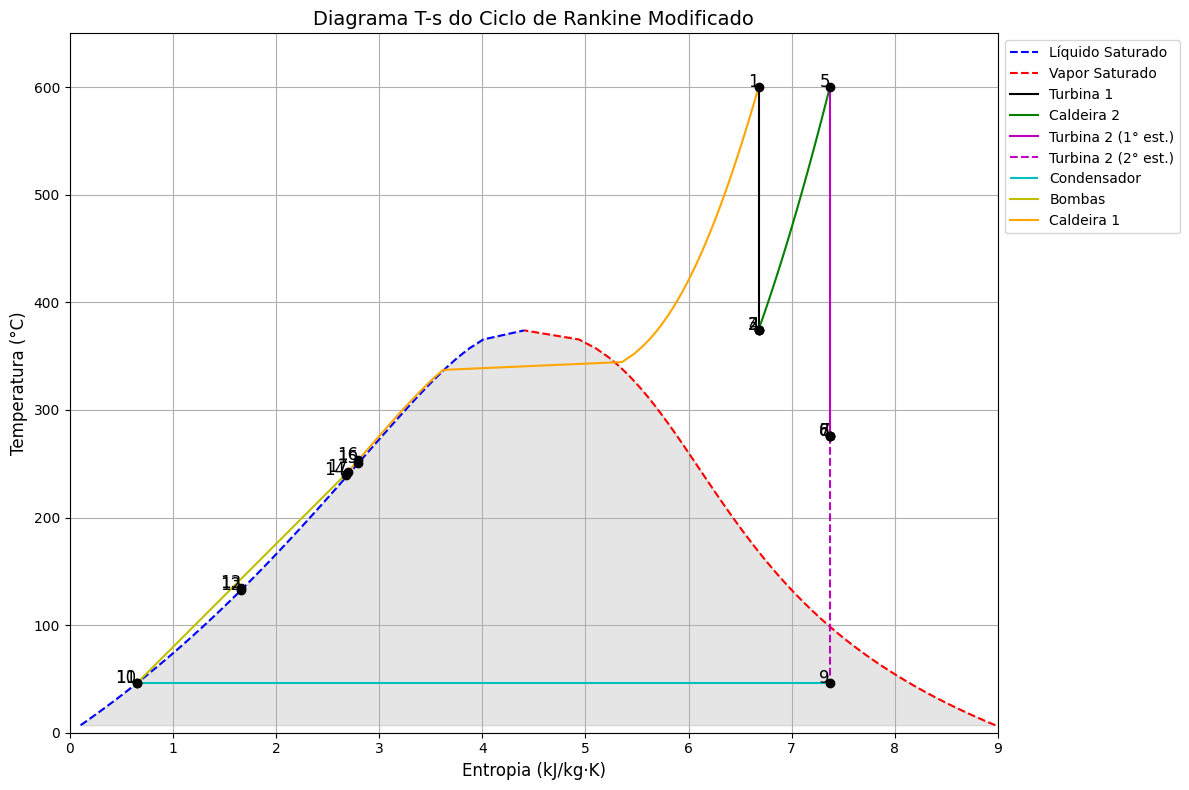

In [2819]:
# Gerar curvas de saturação
pressures_sat = np.logspace(np.log10(1e3), np.log10(22.064e6), 100)  # Pa
Tsat_list = []
s_liq_list = []
s_vap_list = []

for P in pressures_sat:
    try:
        T = CP.PropsSI('T', 'P', P, 'Q', 0, 'Water')
        s_liq = CP.PropsSI('S', 'P', P, 'Q', 0, 'Water') / 1000
        s_vap = CP.PropsSI('S', 'P', P, 'Q', 1, 'Water') / 1000
        Tsat_list.append(T - 273.15)
        s_liq_list.append(s_liq)
        s_vap_list.append(s_vap)
    except:
        continue

# Criar o dicionário pontos a partir de df_correntes
pontos = {}

# Iterar sobre as linhas do DataFrame
for corrente, row in df_correntes[['Entropia (kJ/kg·K)', 'Temperatura (°C)']].iterrows():
    pontos[corrente] = {
        's': row['Entropia (kJ/kg·K)'],
        'T': row['Temperatura (°C)']
    }

# Plotar curvas de saturação
plt.figure(figsize=(12, 8))
plt.plot(s_liq_list, Tsat_list, 'b--', label='Líquido Saturado')
plt.plot(s_vap_list, Tsat_list, 'r--', label='Vapor Saturado')
plt.fill_betweenx(Tsat_list, s_liq_list, s_vap_list, color='gray', alpha=0.2)

# Processos do ciclo
# 1→2: Expansão isentrópica (Turbina 1)
plt.plot([pontos[1]['s'], pontos[2]['s']], [pontos[1]['T'], pontos[2]['T']], 'k-', label='Turbina 1')

# 2→5: Reaquecimento a 4 MPa (Caldeira 2)
P_4MPa = 4e6
T_values = np.linspace(pontos[2]['T'], pontos[5]['T'], 50)
s_values = [CP.PropsSI('S', 'P', P_4MPa, 'T', T+273.15, 'Water')/1000 for T in T_values]
plt.plot(s_values, T_values, 'g-', label='Caldeira 2')

# 5→6→9: Expansão isentrópica (Turbina 2)
plt.plot([pontos[5]['s'], pontos[6]['s']], [pontos[5]['T'], pontos[6]['T']], 'm-', label='Turbina 2 (1° est.)')
plt.plot([pontos[6]['s'], pontos[9]['s']], [pontos[6]['T'], pontos[9]['T']], 'm--', label='Turbina 2 (2° est.)')

# 9→10: Condensador (pressão constante)
plt.hlines(pontos[9]['T'], pontos[9]['s'], pontos[10]['s'], colors='c', label='Condensador')

# 10→17→1: Bombas e Caldeira 1
plt.plot([pontos[10]['s'], pontos[17]['s']], [pontos[10]['T'], pontos[17]['T']], 'y-', label='Bombas')
P_15MPa = 15e6
T_values = np.linspace(pontos[17]['T'], pontos[1]['T'], 50)
s_values = [CP.PropsSI('S', 'P', P_15MPa, 'T', T+273.15, 'Water')/1000 for T in T_values]
plt.plot(s_values, T_values, 'orange', label='Caldeira 1')

# Plotar pontos
for p in pontos:
    plt.plot(pontos[p]['s'], pontos[p]['T'], 'ko')
    plt.text(pontos[p]['s'], pontos[p]['T'], f'{p}', fontsize=12, ha='right')

# Configurações do gráfico
plt.xlabel('Entropia (kJ/kg·K)', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.title('Diagrama T-s do Ciclo de Rankine Modificado', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xlim(0, 9)
plt.ylim(0, 650)
plt.tight_layout()
plt.savefig('./images/DiagramaTs.png')
plt.show()

e) Realizar análise paramétrica no desempenho do ciclo considerando a 
variação das pressões de descargas das turbinas; e a temperatura de saída 
da caldeira 1; (para esta análise, plote gráficos para demonstrar a influência 
desses parâmetros na eficiência térmica do ciclo). Discuta os resultados 
obtidos.

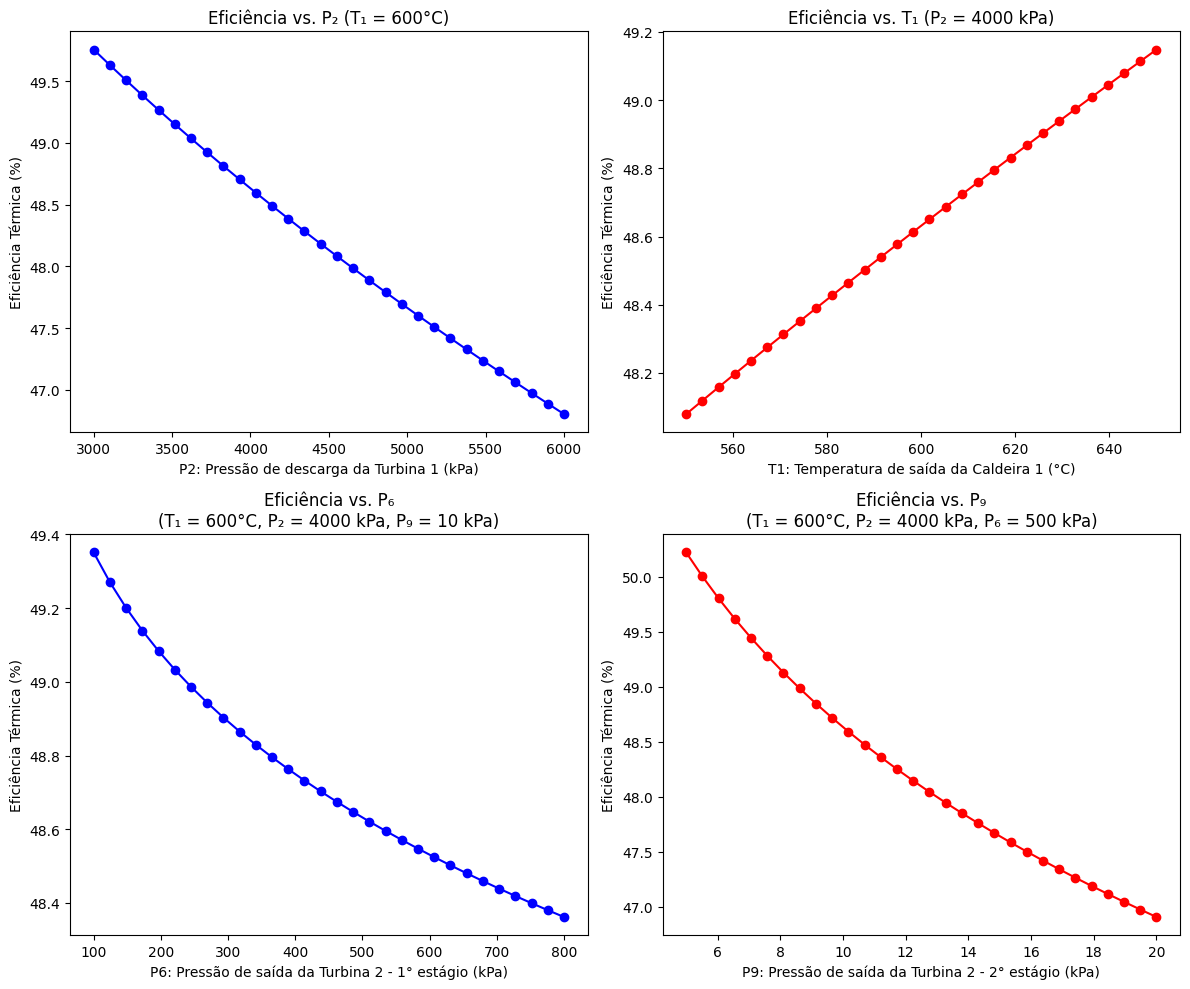

In [2820]:
def simulate_cycle(T1, P2, P6=500, P9=10):
    """
    Simula o ciclo modificado e retorna:
      - eta: eficiência térmica,
      - net_work: trabalho líquido (kW),
      - Q_in_total: calor total fornecido (kW).

    Parâmetros:
      T1: Temperatura de saída da Caldeira 1 (°C)
      P2: Pressão de descarga da Turbina 1 (kPa)
      P6: Pressão de saída da Turbina 2 - 1° estágio (kPa)
      P9: Pressão de saída da Turbina 2 - 2° estágio (kPa)
    """
    m_dot1 = 10000  # kg/h
    P1 = 15000      # kPa (saída da Caldeira 1)

    # Estado 1: Saída da Caldeira 1 (convertendo T para Kelvin)
    h1, s1 = obter_propriedades(P1*1e3, T=T1+273.15)

    # Estado 2: Saída da Turbina 1 (expansão isentrópica)
    h2, s2 = obter_propriedades(P2*1e3, s=s1)

    # Estado 3: Entrada da Caldeira 2 (fluxo principal)
    m_dot3 = 0.82 * m_dot1
    h3, s3 = h2, s2

    # Estado 4: Ramificação (fluxo que seguirá para o trocador de calor)
    m_dot4 = 0.18 * m_dot1
    h4, s4 = h2, s2

    # Estado 5: Saída da Caldeira 2 (4000 kPa e 600°C)
    P5 = 4000  # kPa
    T5 = 600   # °C
    m_dot5 = m_dot3
    h5, s5 = obter_propriedades(P5*1e3, T=T5+273.15)

    # Trabalho da Turbina 1
    Wt1 = (m_dot1/3600) * (h1 - h2)

    # Calor fornecido na Caldeira 2
    Q_in_cald2 = (m_dot5/3600) * (h5 - h4)

    # Estado 6: Saída da Turbina 2 (1° estágio) - expansão isentrópica
    h6, s6 = obter_propriedades(P6*1e3, s=s5)
    Wt2_1 = (m_dot5/3600) * (h5 - h6)

    # Estado 7: Ramificação após Turbina 2 (fluxo 1)
    m_dot7 = 0.13 * m_dot5
    h7, s7 = h6, s6

    # Estado 8: Ramificação após Turbina 2 (fluxo 2)
    m_dot8 = 0.87 * m_dot5
    h8, s8 = h6, s6

    # Estado 9: Saída da Turbina 2 (2° estágio) - expansão isentrópica
    h9, _ = obter_propriedades(P9*1e3, s=s6)
    m_dot9 = m_dot8
    Wt2_2 = (m_dot8/3600) * (h8 - h9)

    # Estado 10: Saída do Condensador (líquido saturado a P9)
    P10 = P9
    m_dot10 = m_dot9
    h10 = CP.PropsSI('H', 'P', P10*1e3, 'Q', 0, 'Water') / 1000
    Q_out_cond = (m_dot9/3600) * (h9 - h10)

    # Estado 11: Saída da Bomba 1 (aumento de pressão para P11)
    P11 = 500  # kPa
    m_dot11 = m_dot10
    h11 = h10 + (P11*1e3 - P10*1e3) / (1000*1000)
    Wb1 = (m_dot10/3600) * (h11 - h10)

    # Estado 12: Mistura dos fluxos de Bomba 1 e ramificação da Turbina 2 (fluxo 7)
    P12 = P11
    m_dot12 = m_dot11 + m_dot7
    h12 = (m_dot11 * h11 + m_dot7 * h7) / m_dot12

    # Estado 13: Saída da Bomba 2 (aumento de pressão para P13)
    P13 = 15000  # kPa
    m_dot13 = m_dot12
    s12_calc = CP.PropsSI('S', 'P', P12*1e3, 'H', h12*1000, 'Water') / 1000
    h13 = CP.PropsSI('H', 'P', P13*1e3, 'S', s12_calc*1000, 'Water') / 1000
    Wb2 = (m_dot12/3600) * (h13 - h12)

    # Estado 14: Saída do trocador de calor
    P14 = P13
    m_dot14 = m_dot13
    h14 = (m_dot13 * h13 + m_dot4 * h4) / (m_dot13 + m_dot4)

    # Estado 15: Saída do trocador de calor para a Bomba 3 (a P15 = P2)
    P15 = P2
    m_dot15 = m_dot4
    h15 = CP.PropsSI('H', 'P', P15*1e3, 'Q', 0, 'Water') / 1000

    # Estado 16: Saída da Bomba 3 (aumento de pressão para P16)
    P16 = 15000  # kPa
    m_dot16 = m_dot15
    s15 = CP.PropsSI('S', 'P', P15*1e3, 'Q', 0, 'Water') / 1000
    h16 = CP.PropsSI('H', 'P', P16*1e3, 'S', s15*1000, 'Water') / 1000
    Wb3 = (m_dot15/3600) * (h16 - h15)

    # Estado 17: Mistura dos fluxos de Bomba 3 e do trocador de calor
    P17 = P16
    m_dot17 = m_dot16 + m_dot14
    h17 = (m_dot16 * h16 + m_dot14 * h14) / m_dot17

    # Calor fornecido na Caldeira 1
    Q_in_cald1 = (m_dot1/3600) * (h1 - h17)

    # Trabalho líquido e eficiência térmica
    net_work = Wt1 + Wt2_1 + Wt2_2 - Wb1 - Wb2 - Wb3
    Q_in_total = Q_in_cald1 + Q_in_cald2
    eta = net_work / Q_in_total

    return eta, net_work, Q_in_total

# ----- Análise Paramétrica -----
# 1) Variação de P₂ (Pressão de descarga da Turbina 1)
P2_values = np.linspace(3000, 6000, 30)  # kPa
eta_values_P2 = []
for p2 in P2_values:
    eta, _, _ = simulate_cycle(T1=600, P2=p2, P6=500, P9=10)
    eta_values_P2.append(eta * 100)  # em %

# 2) Variação de T₁ (Temperatura de saída da Caldeira 1)
T1_values = np.linspace(550, 650, 30)  # °C
eta_values_T1 = []
for T1_val in T1_values:
    eta, _, _ = simulate_cycle(T1=T1_val, P2=4000, P6=500, P9=10)
    eta_values_T1.append(eta * 100)

# 3) Variação de P₆ (Saída da Turbina 2 - 1° estágio)
P6_values = np.linspace(100, 800, 30)  # kPa
eta_values_P6 = []
for p6 in P6_values:
    eta, _, _ = simulate_cycle(T1=600, P2=4000, P6=p6, P9=10)
    eta_values_P6.append(eta * 100)

# 4) Variação de P₉ (Saída da Turbina 2 - 2° estágio)
P9_values = np.linspace(5, 20, 30)  # kPa
eta_values_P9 = []
for p9 in P9_values:
    eta, _, _ = simulate_cycle(T1=600, P2=4000, P6=500, P9=p9)
    eta_values_P9.append(eta * 100)

# ----- Plotando os Quatro Gráficos em Uma Única Imagem -----
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gráfico 1: Eficiência vs. P₂
axs[0, 0].plot(P2_values, eta_values_P2, 'b-o')
axs[0, 0].set_xlabel('P2: Pressão de descarga da Turbina 1 (kPa)')
axs[0, 0].set_ylabel('Eficiência Térmica (%)')
axs[0, 0].set_title('Eficiência vs. P₂ (T₁ = 600°C)')

# Gráfico 2: Eficiência vs. T₁
axs[0, 1].plot(T1_values, eta_values_T1, 'r-o')
axs[0, 1].set_xlabel('T1: Temperatura de saída da Caldeira 1 (°C)')
axs[0, 1].set_ylabel('Eficiência Térmica (%)')
axs[0, 1].set_title('Eficiência vs. T₁ (P₂ = 4000 kPa)')

# Gráfico 3: Eficiência vs. P₆
axs[1, 0].plot(P6_values, eta_values_P6, 'b-o')
axs[1, 0].set_xlabel('P6: Pressão de saída da Turbina 2 - 1° estágio (kPa)')
axs[1, 0].set_ylabel('Eficiência Térmica (%)')
axs[1, 0].set_title('Eficiência vs. P₆\n(T₁ = 600°C, P₂ = 4000 kPa, P₉ = 10 kPa)')

# Gráfico 4: Eficiência vs. P₉
axs[1, 1].plot(P9_values, eta_values_P9, 'r-o')
axs[1, 1].set_xlabel('P9: Pressão de saída da Turbina 2 - 2° estágio (kPa)')
axs[1, 1].set_ylabel('Eficiência Térmica (%)')
axs[1, 1].set_title('Eficiência vs. P₉\n(T₁ = 600°C, P₂ = 4000 kPa, P₆ = 500 kPa)')

plt.tight_layout()
plt.savefig('./images/analise_parametrica.png')
plt.show()